# DVD Rental Data Dictionary

## **Description**  
This dataset contains information about DVD rentals, including rental details, pricing, movie attributes, and rating categories.
A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

## **Features**  

### **Rental Details**  
- **`rental_date`**: The date and time when the customer rents the DVD.  
- **`return_date`**: The date and time when the customer returns the DVD.  
- **`amount`**: The amount paid by the customer for renting the DVD.  
- **`amount_2`**: The square of `amount`.  
- **`rental_rate`**: The rate at which the DVD is rented.  
- **`rental_rate_2`**: The square of `rental_rate`.  

### **Movie Attributes**  
- **`release_year`**: The year the movie was released.  
- **`length`**: The duration of the movie in minutes.  
- **`length_2`**: The square of `length`.  
- **`replacement_cost`**: The cost for the company to replace the DVD.  
- **`special_features`**: Special features included in the DVD, such as trailers or deleted scenes.  
  



# Data Exploration and Preprocessing

In [117]:
# importing libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# For lasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Run OLS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


## Load and Explore Dataset

In [118]:
# Read in data
df_rental = pd.read_csv("D:\\rental_info.csv")

In [119]:
df_rental.shape

(15861, 15)

In [120]:
df_rental.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [121]:
df_rental.dtypes.value_counts()

float64    8
int64      4
object     3
Name: count, dtype: int64

In [122]:
df_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


## Handling missing values

In [123]:
# function to count missing data and in which feature.
def missing_data(data):
    nb_values = data.isnull().sum().sort_values(ascending = False) #contains the number of values missing
    percent_values = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False) #contains the percentage of values missing
    return pd.concat([nb_values, percent_values], axis=1, keys=['Number of Missing Values', 'Percentage of Missing Values'])
missing_data(df_rental).head(5)

,Number of Missing Values,Percentage of Missing Values
rental_date,0,0.0
return_date,0,0.0
amount,0,0.0
release_year,0,0.0
rental_rate,0,0.0


## Handling Douplicate Data

In [124]:
#Show Duplicates
duplicates = df_rental.duplicated()
duplicates.value_counts()

False    15861
Name: count, dtype: int64

In [125]:
# there are no duplicates rows
duplicate_rows = df_rental[df_rental.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [rental_date, return_date, amount, release_year, rental_rate, length, replacement_cost, special_features, NC-17, PG, PG-13, R, amount_2, length_2, rental_rate_2]
Index: []


# Features Engineering

In [126]:
# Add information on rental duration
df_rental["rental_length"] = pd.to_datetime(df_rental["return_date"]) - pd.to_datetime(df_rental["rental_date"])
df_rental["rental_length_days"] = df_rental["rental_length"].dt.days

In [127]:
### Add dummy variables
# Add dummy for deleted scenes
df_rental["deleted_scenes"] =  np.where(df_rental["special_features"].str.contains("Deleted Scenes"), 1, 0)
# Add dummy for behind the scenes
df_rental["behind_the_scenes"] =  np.where(df_rental["special_features"].str.contains("Behind the Scenes"), 1, 0)

In [128]:
# Choose columns to drop
cols_to_drop = ["special_features", "rental_length", "rental_date", "return_date"]
df_rental_cleaned = df_rental.drop(cols_to_drop, axis=1)

## Exploratory Data Analysis (EDA)

In [129]:
# df_train_standrized summary statistics
df_rental_cleaned.describe().round(2)

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
count,15861.00,15861.00,15861.00,15861.00,15861.00,15861.0,15861.0,15861.00,15861.0,15861.00,15861.00,15861.00,15861.00,15861.0,15861.00
mean,4.22,2006.89,2.94,114.99,20.22,0.2,0.2,0.22,0.2,23.36,14832.84,11.39,4.53,0.5,0.54
std,2.36,2.03,1.65,40.11,6.08,0.4,0.4,0.42,0.4,23.50,9393.43,10.01,2.64,0.5,0.50
min,0.99,2004.00,0.99,46.00,9.99,0.0,0.0,0.00,0.0,0.98,2116.00,0.98,0.00,0.0,0.00
25%,2.99,2005.00,0.99,81.00,14.99,0.0,0.0,0.00,0.0,8.94,6561.00,0.98,2.00,0.0,0.00
50%,3.99,2007.00,2.99,114.00,20.99,0.0,0.0,0.00,0.0,15.92,12996.00,8.94,5.00,0.0,1.00
75%,4.99,2009.00,4.99,148.00,25.99,0.0,0.0,0.00,0.0,24.90,21904.00,24.90,7.00,1.0,1.00
max,11.99,2010.00,4.99,185.00,29.99,1.0,1.0,1.00,1.0,143.76,34225.00,24.90,9.00,1.0,1.00


# Machine learning models

In [130]:
# Split into feature and target sets
X = df_rental_cleaned.drop("rental_length_days", axis=1)
y = df_rental_cleaned["rental_length_days"]

In [131]:
# Further split into training and test data
X_train,X_test,y_train,y_test = train_test_split(X, 
                                                 y, 
                                                 test_size=0.2, 
                                                 random_state=9)

## Lasso model(choosing columns with positive coefficients)

In [135]:
# Create the Lasso model
lasso = Lasso(alpha=0.3, random_state=9) 

# Train the model and access the coefficients
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

# Perform feature selectino by choosing columns with positive coefficients
X_lasso_train, X_lasso_test = X_train.iloc[:, lasso_coef > 0], X_test.iloc[:, lasso_coef > 0]

## OLS model

In [154]:
# Run OLS models on lasso chosen regression
ols = LinearRegression()
ols = ols.fit(X_lasso_train, y_train)
y_test_pred = ols.predict(X_lasso_test)
score =  ols.score(X_lasso_test,y_test_pred )
mse_lin_reg_lasso = mean_squared_error(y_test, y_test_pred)

In [155]:
print(f"Mean Squared Error of days: {mse_lin_reg_lasso:.4f}")

Mean Squared Error of days: 4.8123


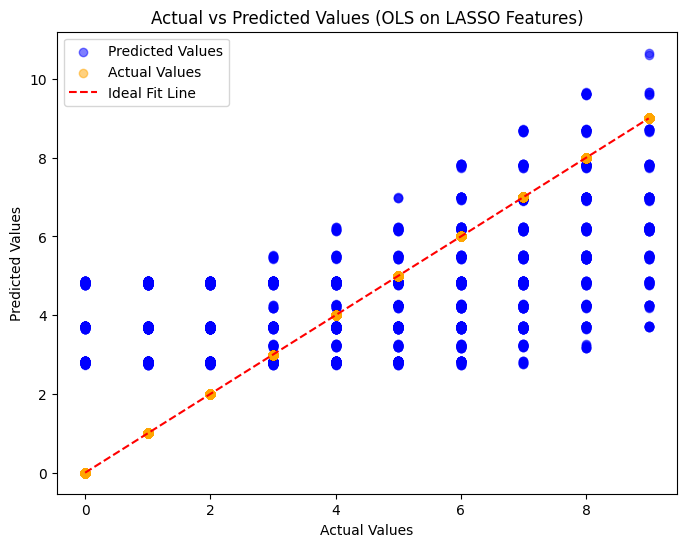

In [148]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, color="blue", alpha=0.5, label="Predicted Values")
plt.scatter(y_test, y_test, color="orange", alpha=0.5, label="Actual Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal Fit Line")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (OLS on LASSO Features)")
plt.legend()
plt.show()

# Random forest

In [137]:
# Random forest hyperparameter space
param_dist = {'n_estimators': np.arange(1,101,1),
          'max_depth':np.arange(1,11,1)}

In [139]:
# Create a random forest regressor
rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist, 
                                 cv=5, 
                                 random_state=9)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best hyper param
hyper_params = rand_search.best_params_

# Run the random forest on the chosen hyper parameters
rf = RandomForestRegressor(n_estimators=hyper_params["n_estimators"], 
                           max_depth=hyper_params["max_depth"], 
                           random_state=9)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
mse_random_forest= mean_squared_error(y_test, rf_pred)

# Random forest gives lowest MSE so:
best_model = rf
best_mse = mse_random_forest

In [156]:
print(f"Mean Squared Error of days: {best_mse:.2f}")

Mean Squared Error of days: 2.23


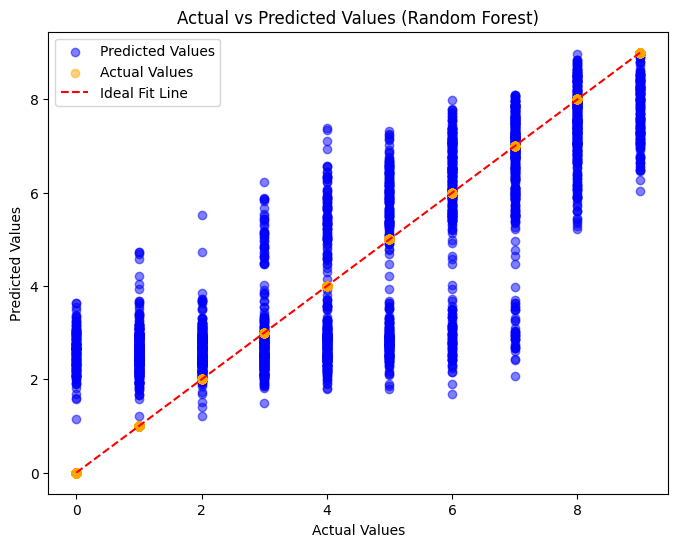

In [149]:
# Create a scatter plot for actual vs predicted values
plt.figure(figsize=(8,6))
plt.scatter(y_test, rf_pred, color="blue", alpha=0.5, label="Predicted Values")
plt.scatter(y_test, y_test, color="orange", alpha=0.5, label="Actual Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal Fit Line")

# Labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (Random Forest)")
plt.legend()
plt.show()